In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.stats import spearmanr as spr
from scipy.stats import pearsonr as r

In [2]:
#from obs_read import read_upperair_obs
#import datetime as dt
#df=read_upperair_obs(dt.datetime(2005,1,1),dt.datetime(2018,12,31),"UA_wrfpython",code="wrfpython")

In [18]:
#Load AWS data and point data
stn_map = {14015:"Darwin",66037:"Sydney",16001:"Woomera",23034:"Adelaide"}
obs = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/UA_wrfpython.pkl")
obs["stn_name"] = obs["stn_id"].map(stn_map)
obs.columns = [str(col) + '_obs' for col in obs.columns]

barra = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/barra_allvars_v3_2005_2018.pkl").rename(columns={"loc_id":"stn_name"})
barra["bdsd"] = np.squeeze(1 / ( 1 + np.exp( -(
        barra["ebwd"] * 6.1e-2
        + barra["Umean800_600"] * 1.5e-1
        + barra["lr13"] * 9.4e-1
        + barra["rhmin13"] * 3.9e-2
        + barra["srhe_left"] * 1.7e-2
        + barra["q_melting"] * 3.8e-1
        + barra["eff_lcl"] * 4.7e-4
        - 1.3e+1) ) ) )
barra = barra[np.in1d(barra.stn_name,["Adelaide","Darwin","Sydney","Woomera"])]
barra.columns = [str(col) + '_barra' for col in barra.columns]

era5 = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/era5_allvars_v3_2005_2018.pkl").rename(columns={"loc_id":"stn_name"})
era5["bdsd"] = np.squeeze(1 / ( 1 + np.exp( -(
        era5["ebwd"] * 6.1e-2
        + era5["Umean800_600"] * 1.5e-1
        + era5["lr13"] * 9.4e-1
        + era5["rhmin13"] * 3.9e-2
        + era5["srhe_left"] * 1.7e-2
        + era5["q_melting"] * 3.8e-1
        + era5["eff_lcl"] * 4.7e-4
        - 1.3e+1) ) ) )
era5 = era5[np.in1d(era5.stn_name,["Adelaide","Darwin","Sydney","Woomera"])]
era5.columns = [str(col) + '_era5' for col in era5.columns]

merra2 = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/points/merra2_2005_2018.pkl").rename(columns={"loc_id":"stn_name"})
merra2_resampled = pd.DataFrame()
for loc in ["Adelaide","Darwin","Sydney","Woomera"]:
    merra2_resampled = pd.concat([merra2_resampled, merra2.loc[merra2["stn_name"]==loc].set_index("time").resample("1H").nearest()])
merra2_resampled.reset_index(inplace=True)
merra2_resampled.columns = [str(col) + '_merra2' for col in merra2_resampled.columns]
########

In [19]:
merged=pd.concat([barra.set_index(["time_barra","stn_name_barra"]),
                  era5.set_index(["time_era5","stn_name_era5"]),
                  merra2_resampled.set_index(["time_merra2","stn_name_merra2"]),
                  obs.set_index(["stn_name_obs"],append=True)],
          axis=1).dropna()


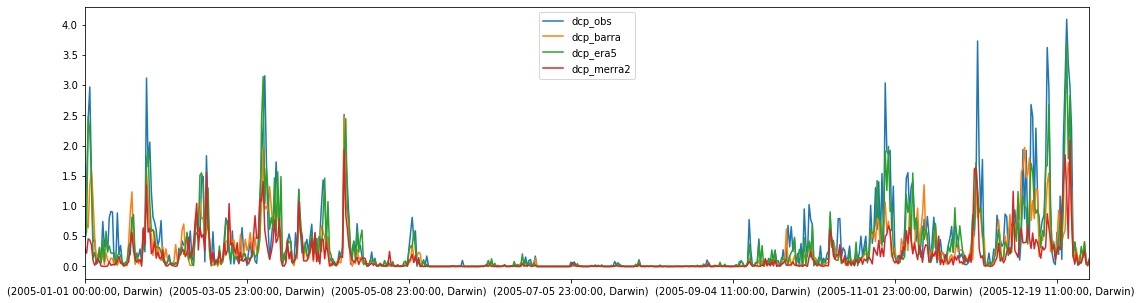

In [20]:
plt.figure(figsize=[18,5])
ax=plt.gca()
merged[["dcp_obs","dcp_barra","dcp_era5","dcp_merra2"]].loc[(slice("2005-01-01","2005-12-31"),"Darwin"),:].plot(ax=ax)

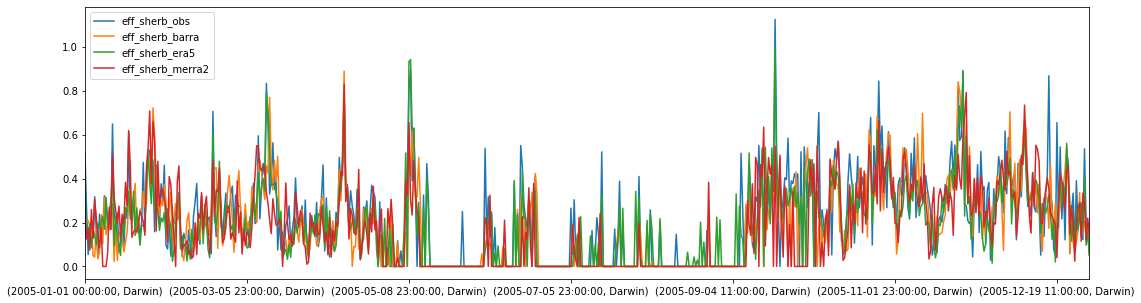

In [23]:
plt.figure(figsize=[18,5])
ax=plt.gca()
merged[["eff_sherb_obs","eff_sherb_barra","eff_sherb_era5","eff_sherb_merra2"]].loc[(slice("2005-01-01","2005-12-31"),"Darwin"),:].plot(ax=ax)

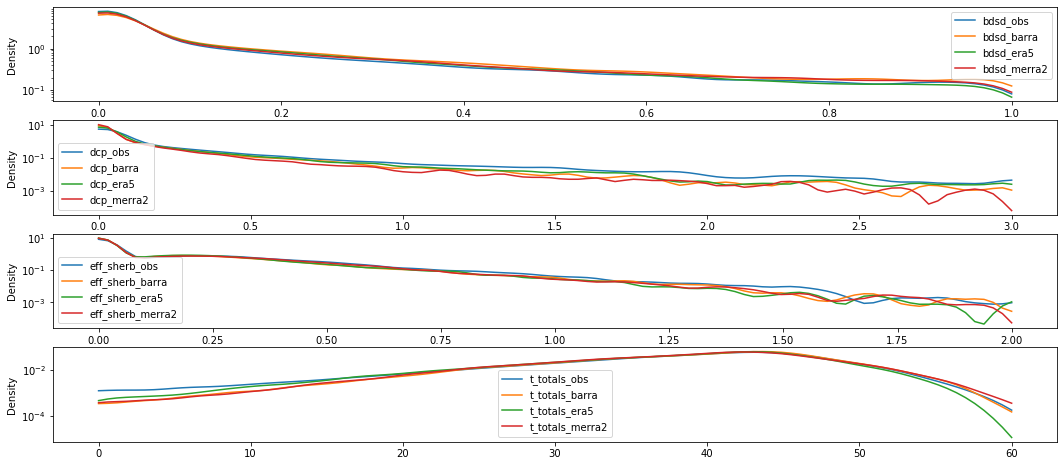

In [24]:
plt.figure(figsize=[18,8])
ax=plt.subplot(4,1,1)
p="bdsd"
merged[[p+"_obs",p+"_barra",p+"_era5",p+"_merra2"]].plot(ax=ax,kind="kde",ind=np.linspace(0,1,100))
plt.yscale("log")

ax=plt.subplot(4,1,2)
p="dcp"
merged[[p+"_obs",p+"_barra",p+"_era5",p+"_merra2"]].plot(ax=ax,kind="kde",ind=np.linspace(0,3,100))
plt.yscale("log")

ax=plt.subplot(4,1,3)
p="eff_sherb"
merged[[p+"_obs",p+"_barra",p+"_era5",p+"_merra2"]].plot(ax=ax,kind="kde",ind=np.linspace(0,2,100))
plt.yscale("log")

ax=plt.subplot(4,1,4)
p="t_totals"
merged[[p+"_obs",p+"_barra",p+"_era5",p+"_merra2"]].plot(ax=ax,kind="kde",ind=np.linspace(0,60,100))
plt.yscale("log")


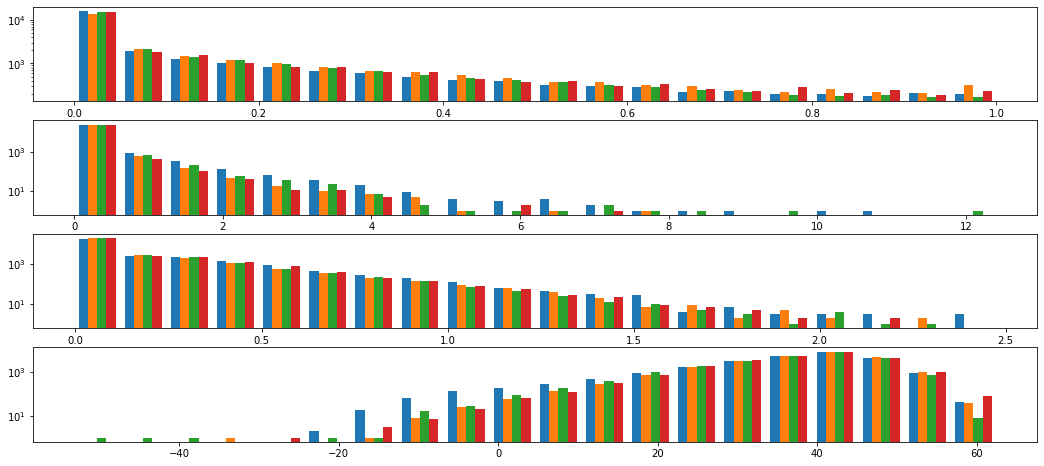

In [25]:
plt.figure(figsize=[18,8])
b=20

ax=plt.subplot(4,1,1)
p="bdsd"
plt.hist(merged[[p+"_obs",p+"_barra",p+"_era5",p+"_merra2"]].values, bins=b)
plt.yscale("log")

ax=plt.subplot(4,1,2)
p="dcp"
plt.hist(merged[[p+"_obs",p+"_barra",p+"_era5",p+"_merra2"]].values, bins=b)
plt.yscale("log")

ax=plt.subplot(4,1,3)
p="eff_sherb"
plt.hist(merged[[p+"_obs",p+"_barra",p+"_era5",p+"_merra2"]].values, bins=b)
plt.yscale("log")

ax=plt.subplot(4,1,4)
p="t_totals"
plt.hist(merged[[p+"_obs",p+"_barra",p+"_era5",p+"_merra2"]].values, bins=b)
plt.yscale("log")

Text(0.3, 0.09, 'Observed values')

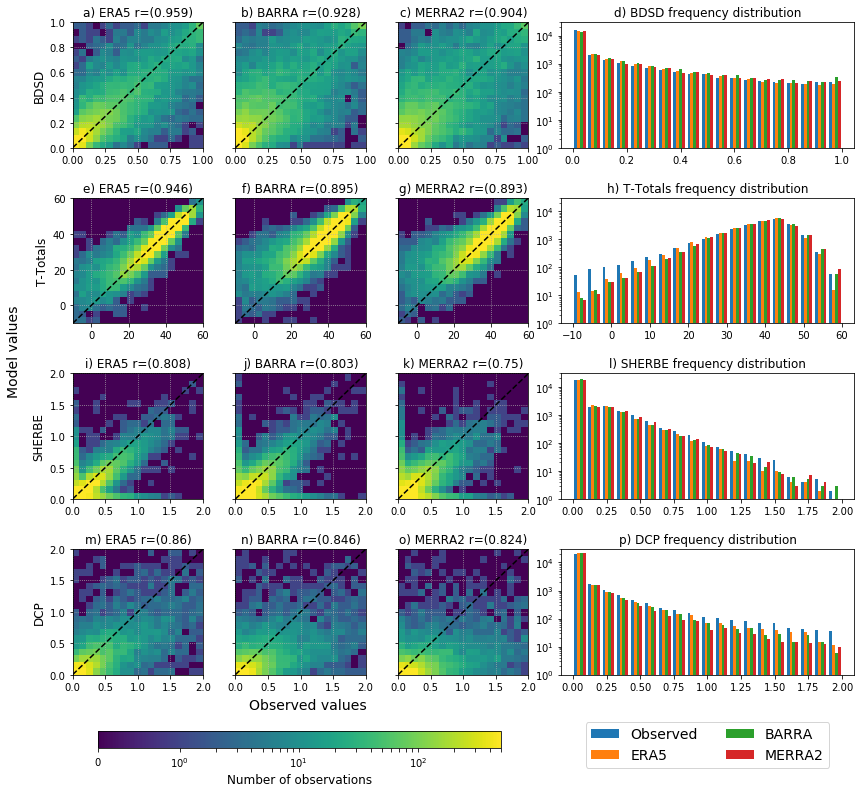

In [134]:
def hist2d_plot(obs, mod, xlim, mname, xticklab=True, yticklab=False, corr="spearman", ylab=False):
    plt.hist2d(obs, mod, norm=matplotlib.colors.SymLogNorm(1), vmax=500, bins=np.linspace(xlim[0],xlim[1],20))
    plt.plot([xlim[0], xlim[1]], [xlim[0],xlim[1]], color="k", ls="--")
    if corr=="spearman":
        plt.title(mname+" r=("+str(round(spr(obs,mod).correlation,3))+")")
    elif corr=="pearson":
        plt.title(mname+" r=("+str(round(r(obs,mod)[0],3))+")")
    plt.gca().grid(ls=":")
    if not xticklab:
        plt.gca().set_xticklabels("")
    if not yticklab:
        plt.gca().set_yticklabels("")
    if ylab:
        plt.ylabel(ylab, size=12)

fig=plt.figure(figsize=[14,12])
plt.subplot2grid((4,5),(0,0)); hist2d_plot(merged["bdsd_obs"], merged["bdsd_era5"], [0,1], "a) ERA5" ,yticklab=True, ylab="BDSD")
plt.subplot2grid((4,5),(1,0)); hist2d_plot(merged["t_totals_obs"], merged["t_totals_era5"], [-10,60], "e) ERA5", yticklab=True, ylab="T-Totals")
plt.subplot2grid((4,5),(2,0)); hist2d_plot(merged["eff_sherb_obs"], merged["eff_sherb_era5"], [0,2], "i) ERA5", yticklab=True, ylab="SHERBE")
plt.subplot2grid((4,5),(3,0)); hist2d_plot(merged["dcp_obs"], merged["dcp_era5"], [0,2], "m) ERA5", yticklab=True, ylab="DCP")

plt.subplot2grid((4,5),(0,1)); hist2d_plot(merged["bdsd_obs"], merged["bdsd_barra"], [0,1], "b) BARRA")
plt.subplot2grid((4,5),(1,1)); hist2d_plot(merged["t_totals_obs"], merged["t_totals_barra"], [-10,60], "f) BARRA")
plt.subplot2grid((4,5),(2,1)); hist2d_plot(merged["eff_sherb_obs"], merged["eff_sherb_barra"], [0,2], "j) BARRA")
plt.subplot2grid((4,5),(3,1)); hist2d_plot(merged["dcp_obs"], merged["dcp_barra"], [0,2], "n) BARRA")

plt.subplot2grid((4,5),(0,2)); hist2d_plot(merged["bdsd_obs"], merged["bdsd_merra2"], [0,1], "c) MERRA2")
plt.subplot2grid((4,5),(1,2)); hist2d_plot(merged["t_totals_obs"], merged["t_totals_merra2"], [-10,60], "g) MERRA2")
plt.subplot2grid((4,5),(2,2)); hist2d_plot(merged["eff_sherb_obs"], merged["eff_sherb_merra2"], [0,2], "k) MERRA2")
plt.subplot2grid((4,5),(3,2)); hist2d_plot(merged["dcp_obs"], merged["dcp_merra2"], [0,2], "o) MERRA2")

cb=plt.colorbar(cax=plt.axes([0.15,0.04,0.4,0.02]), orientation="horizontal")
cb.set_label("Number of observations", size=12)
plt.subplots_adjust(hspace=0.4, wspace=0.25)

def hist_plot(merged, p, xlim, title):
    plt.hist(merged[[p+"_obs",p+"_era5",p+"_barra",p+"_merra2"]].values, bins=np.linspace(xlim[0],xlim[1],20), label=["Observed","ERA5","BARRA","MERRA2"])
    plt.yscale("log")
    plt.ylim(1,3e4)
    plt.title(title)
    
plt.subplot2grid((4,5),(0,3), colspan=2); hist_plot(merged, "bdsd", [0,1], "d) BDSD frequency distribution")
plt.subplot2grid((4,5),(1,3), colspan=2); hist_plot(merged, "t_totals", [-10,60], "h) T-Totals frequency distribution")
plt.subplot2grid((4,5),(2,3), colspan=2); hist_plot(merged, "eff_sherb", [0,2], "l) SHERBE frequency distribution")
plt.subplot2grid((4,5),(3,3), colspan=2); hist_plot(merged, "dcp", [0,2], "p) DCP frequency distribution")

plt.legend(loc=8,ncol=2,bbox_to_anchor=(0.5,-0.8), fontsize=14)

fig.text(0.06,0.5,"Model values", rotation=90, va="center", size=14)
fig.text(0.3,0.09,"Observed values", rotation=0, va="center", size=14)
